# Text processing

### Imports

In [1]:
import importlib
import pandas as pd
import modules.data_processing
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
import spacy
import string
import nltk
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from modules.data_processing import *

In [2]:
importlib.reload(modules.data_processing)
from modules.data_processing import *

In [3]:
DATA_PATH = './data/wiki-RfA.txt'

### Loading Processed Dataset

In [4]:
wiki_df = extract_data(DATA_PATH)
process_dataframe(wiki_df)

In [5]:
wiki_df.head(10)

,SRC,TGT,VOT,RES,YEA,DAT,TXT,ELECTION_ID
0,Steel1943,BDD,1,1,2013,2013-04-19 23:13:00,'''Support''' as co-nom.,1
1,Cuchullain,BDD,1,1,2013,2013-04-20 01:04:00,'''Support''' as nominator.--,1
2,INeverCry,BDD,1,1,2013,2013-04-19 23:43:00,'''Support''' per noms.,1
3,Cncmaster,BDD,1,1,2013,2013-04-20 00:11:00,'''Support''' per noms. BDD is a strong contri...,1
4,Miniapolis,BDD,1,1,2013,2013-04-20 00:56:00,"'''Support''', with great pleasure. I work wit...",1
5,Sven Manguard,BDD,1,1,2013,2013-04-20 01:53:00,'''Support''' There are plenty of important ro...,1
6,Ramaksoud2000,BDD,1,1,2013,2013-04-20 02:00:00,'''Support''' per noms. I don't see a reason n...,1
7,RockMagnetist,BDD,1,1,2013,2013-04-20 02:18:00,'''Support''' BDD already wields a broom pret...,1
8,Carrite,BDD,1,1,2013,2013-04-20 02:22:00,'''Support''' barring a completely unexpected ...,1
9,Someguy1221,BDD,1,1,2013,2013-04-20 03:09:00,'''Support''' because I see no good reason not...,1


### Text preprocessing

In [6]:
wiki_copy = wiki_df.copy()

In [7]:
len(wiki_copy[wiki_copy['TXT'] == '']['TXT'])

7190

* We notice that we have 7190 missing values among comments. 

We don't do the replacement at this stage of empty comments by NaN, because we intend to maintain them as strings for the following steps. 

#### Removing the Wiki Markup from the comments

In [8]:
# Make sure that TXT is string
wiki_copy['TXT'] = wiki_copy['TXT'].astype(str)

* We will try to use a python library called "wikitextparser" to easily remove the wiki markup. 

In [9]:
from wikitextparser import remove_markup

In [10]:
# comment example from the dataset 
example = wiki_copy.iloc[66609]['TXT']
example

"Congratulatory '''Support''' - Excellent [[Wikipedia:WikiProject Military history|WikiProject:Military history]] experience with this user. Can be trusted with new responsibility."

In [11]:
remove_markup(example)

'Congratulatory Support - Excellent WikiProject:Military history experience with this user. Can be trusted with new responsibility.'

* The library didn't handle the link removal as expected. Therefore, we will implement a classic function using regular expressions to remove the wiki markup, relying on the Wikitext structure on the website [Wikitext](https://en.wikipedia.org/wiki/Help:Wikitext).

In [12]:
importlib.reload(modules.data_processing)
remove_wiki_markup(example)

'Congratulatory Support - Excellent  experience with this user. Can be trusted with new responsibility.'

* The results is indeed what we want. Let's test on a random sample of comments.

In [13]:
txts = wiki_copy['TXT'].sample(10).copy()
for i, comment in enumerate(txts): 
    print(i, ' : ' , comment)
    print() 

0  :  '''Support'''. If everyone on AfD were like this, I don't think we'd be complaining that it was broken.

1  :  From oppose.

2  :  '''Support''' – He seems to have a good balance between maintenance tasks and article editing.

3  :  '''Oppose''' - Not enough mainspace work. Most of the work has been on community related pages. A very rough estimate of article space edits that aren't twinkle or huggle (Article edits - (Huggle + Twinkle) / 2 (one for main one for talk)) leaves less than one thousand main article edits, which could be fine, but it doesn't count the numerous whitespace edits I see in the history. Compare that to over 1,000 user page edits. ''I have no problem with those kinds of edits'' and those are good things, but I think they need to be discounted appropriately and I don't see a lot of broad based article work. I could support in the future, but not yet.

4  :  '''Strong support''' per nom, answers to all questions thus far, and apparently pleasant, down-to-earth

In [14]:
for i, comment in enumerate(txts): 
    print(i, ' : ' , remove_wiki_markup(comment))
    print() 

0  :  Support. If everyone on AfD were like this, I don't think we'd be complaining that it was broken.

1  :  From oppose.

2  :  Support – He seems to have a good balance between maintenance tasks and article editing.

3  :  Oppose - Not enough mainspace work. Most of the work has been on community related pages. A very rough estimate of article space edits that aren't twinkle or huggle (Article edits - (Huggle + Twinkle) / 2 (one for main one for talk)) leaves less than one thousand main article edits, which could be fine, but it doesn't count the numerous whitespace edits I see in the history. Compare that to over 1,000 user page edits. I have no problem with those kinds of edits and those are good things, but I think they need to be discounted appropriately and I don't see a lot of broad based article work. I could support in the future, but not yet.

4  :  Strong support per nom, answers to all questions thus far, and apparently pleasant, down-to-earth personality. (Extra weight 

* It seems that it works well on the comments of our dataset. We create then a column for cleaned comments.

In [15]:
wiki_copy['CLE'] = wiki_copy['TXT'].apply(remove_wiki_markup)
wiki_copy.head()

,SRC,TGT,VOT,RES,YEA,DAT,TXT,ELECTION_ID,CLE
0,Steel1943,BDD,1,1,2013,2013-04-19 23:13:00,'''Support''' as co-nom.,1,Support as co-nom.
1,Cuchullain,BDD,1,1,2013,2013-04-20 01:04:00,'''Support''' as nominator.--,1,Support as nominator.
2,INeverCry,BDD,1,1,2013,2013-04-19 23:43:00,'''Support''' per noms.,1,Support per noms.
3,Cncmaster,BDD,1,1,2013,2013-04-20 00:11:00,'''Support''' per noms. BDD is a strong contri...,1,Support per noms. BDD is a strong contributor ...
4,Miniapolis,BDD,1,1,2013,2013-04-20 00:56:00,"'''Support''', with great pleasure. I work wit...",1,"Support, with great pleasure. I work with BDD ..."


In [16]:
comments_with_one_char = wiki_copy.loc[(wiki_copy['CLE'].apply(len) == 1)]['CLE'].unique() # one char in the comments
comments_with_one_char

array([' ', '—', '-', '+', '→', "'", '.', '}', '!', '–', 'S', '·', 'I',
       '~', '«', '↔', 'C', ':', '(', '"', '/'], dtype=object)

In [17]:
comments_with_two_char = wiki_copy.loc[(wiki_copy['CLE'].apply(len) == 2)]['CLE'].unique() # two char in the comments
comments_with_two_char

array(['  ', '- ', ' /', '— ', '+ ', '←.', ' [', '. ', "''", ' (', '⇦⇨',
       ' —', 'OK', '}—', ' -', "':", '我是', '++', 'CO', '~ ', ' ~', ' C',
       'Q8', ' ☺', 'No', ' 〈', 'Da', 'S.', '! ', ':)'], dtype=object)

* We will delete those comments containing one or two characters that are meaningless for our study.

In [18]:
wiki_copy['CLE'] = wiki_copy['CLE'].apply(lambda x: '' if len(x) < 3 and x not in ['OK', 'No']  else x)
wiki_copy.loc[(wiki_copy['CLE'].apply(len) < 3)]['CLE'].unique()

array(['', 'OK', 'No'], dtype=object)

In [19]:
wiki_copy.loc[(wiki_copy['CLE'].apply(len) == 3)]['CLE'].unique()

array(['←  ', '!!!', '   ', ' - ', 'Ja.', 'OK.', "I'm", 'Yes', '.  ',
       " ''", '+1–', '賛成 ', ' ••', '} —', '他是好', 'wow', '  ~', "'' ",
       ' ~~', 'No ', '^.^', 'S+1', "''÷", 'yup', ' – ', '➲  ', 'Yay',
       '  |', 'Q3.', '  (', 'yes', '-  ', 'Yup', '➔  ', 'Aye', '➨  ',
       'Q1.', '9 (', '...', 'No.', 'Yep', ' — ', '— (', '— [', '. —',
       "—''", ' :)', ' (/', ' (|', 'yep', '}} ', 'Baa', 'Moo', 'Ok.',
       '!  ', "— '", '. -', ':) ', 's  ', ". '", ' ;)', 'Yo.', ' ()',
       ' ("', ':-)', 'NO.'], dtype=object)

In [20]:
wiki_copy.loc[(wiki_copy['CLE'].apply(len) == 4)]['CLE'].unique()

array(['. - ', 'Yay.', 'Q2 -', 'Sure', 'Yup.', 'Wow.', '.   ', " - '",
       'Yes.', " I'm", 'Duh.', 'Oui ', 'I  /', 'Yeps', '  — ', 'Yes!',
       'Yep.', '. ? ', 'Oui.', 'jo  ', '+1  ', 'Yes ', 'Yep!', ' .  ',
       'See ', '. ~~', 'NEWT', '  (|', '. – ', ' . —', 'AGF ', 'FGJ–',
       'yup.', 'Yep ', '➨ ❝❞', 'Duh!', '-   ', '   ·', 'DUH!', 'Aye.',
       'Meh.', ". ''", "! ''", 'Nom.', '  . ', ' ...', '. — ', "Q5 '",
       'okay', 'Aww.', 'Yup ', 'I am', 'Yea.', ',   ', 'Pig.', '  (/',
       'Yo. ', 'Mop.', 'Wow!', '100%', 'Yes,', "I'm ", 'No. ', 'Bleh',
       '   (', 'Да! ', 'Yay!', '.  |', ' ( -', '«»(|', ', . ', 'TAK!',
       '<3  ', 'yes!', 'Moo.', 'Cool', 'Hai ', 'Pro.', 'Sup ', 'YES!',
       'Ja! ', ' ort', 'yep.', 'Who?', 'Yup,', 'No  ', 'Heh.'],
      dtype=object)

In [21]:
wiki_copy.loc[(wiki_copy['CLE'].apply(len) == 5)]['CLE'].unique()

array(['100%.', 'Yo.  ', 'Yes! ', 'Q2. -', 'Aye.—', 'Sure.', 'nods ',
       'Meh -', 'Yerp.', 'Uhhhh', 'Per .', 'Sold.', 'Duh →', 'Sure ',
       'sure ', 'Yes  ', 'Solid', "Yep '", 'AGF  ', '.    ', 'Okay.',
       'Fine.', '    ·', 'Yup. ', 'Yes. ', 'Yup  ', 'No.  ', 'Yes —',
       'Damn,', 'Nom  ', 'Desu.', 'Yep. ', '.   (', 'Aye. ', 'Ok. —',
       '+S . ', '+S  (', ' () (', 'Aye  ', 'OK.  ', 'ok. —', '+1.  ',
       'Yup! ', 'Duh. ', 'PRO -', 'YES  ', '...  ', 'yes. ', 'Moo  ',
       'AGF. ', 'Oops.', 'Hut+!', 'See .', 'Yep  ', 'Yeap ', 'GL. –',
       ' ..  ', ' ⁿɡ͡b', 'Cool.', 'Fish.', "Sure'", 'Yes..', 'Yup..',
       'Oui!.', ". —''", 'Sure!', 'YEs. ', 'Yay. ', ".  ''", 'Duh .',
       'Gasp!', 'Mooo.', 'Agree', 'Yeah.', 'Sì.  ', 'TINC.', 'Frog.',
       'w00t.', 'SNFA.', 'Aye =', 'Duh  ', 'Okay!', 'Duh -', 'What?',
       'AOL!>', 'No ()', 'Ok.  ', 'Sí.  ', 'Mhmm.', 'Da.  ', '-"-  ',
       'No. -'], dtype=object)

When examining comments with a length greater than 2, we find various words and special characters that we cannot eliminate at this point. 
Due to the extensive number of words and special characters, exhaustive treatment of these comments (by studying the different combinaisons) becomes challenging. 

* Let's see then what are the words by which comments start.

In [22]:
from collections import defaultdict
cleaned_comments = wiki_copy['CLE']

first_word_counts = defaultdict(int)
for comment in cleaned_comments: 
    if isinstance(comment, str) and comment.strip(): 
        first_word = comment.split()[0]
        first_word_counts[first_word] += 1
i = 0       
for word, count in first_word_counts.items(): 
    print(word, ', Occurrence :', count)
    if i == 15: 
        break
    i += 1

Support , Occurrence : 68955
Support, , Occurrence : 7585
Yea, , Occurrence : 6
Support. , Occurrence : 23921
If , Occurrence : 108
Weak , Occurrence : 3370
Support: , Occurrence : 1661
. , Occurrence : 165
Support...opposes , Occurrence : 1
Oppose. , Occurrence : 5538
Although , Occurrence : 68
Oppose , Occurrence : 21033
Fruitless , Occurrence : 3
Neutral , Occurrence : 5864
Yes , Occurrence : 153
Strong , Occurrence : 8394


In [23]:
# Some comments have become empty
# After the wiki markup removal
len(wiki_copy[wiki_copy['CLE'] == '']['CLE'])

9387

* In the cleaned comments, we have now 9387 missing values compared to the initial count of 7190. 

Let's take a look at the additional empty comments resulting from our processing.

In [24]:
wiki_copy[(wiki_copy['CLE'] == '') & (wiki_copy['TXT'] != '') ]

,SRC,TGT,VOT,RES,YEA,DAT,TXT,ELECTION_ID,CLE
156,Rzuwig,Bilby,1,1,2013,2013-05-25 07:11:00,{{pro}} --,2,
276,Mabdul,Darkwind,1,1,2013,2012-12-26 20:39:00,"<small style=""font: 12px Courier New; color: #...",3,
300,Filelakeshoe,Darkwind,1,1,2013,2012-12-27 21:58:00,"<font face=""trebuchet MS"">- [[User:Filelakesho...",3,
427,LlamaAl,INeverCry,1,1,2013,2013-01-31 13:17:00,--,4,
441,Jan eissfeldt,INeverCry,1,1,2013,2013-01-31 20:03:00,--,4,
...,...,...,...,...,...,...,...,...,...
197931,Hcheney,Snowspinner,1,0,2004,2004-05-30 22:25:00,[[User:Hcheney/Support|Support]] --,3864,
197938,Anthony DiPierro,Snowspinner,1,0,2004,NaT,[[User:Hcheney/Support|Support]] [[User:Anthon...,3864,
197940,GeneralPatton,Snowspinner,1,0,2004,2004-06-02 18:13:00,--,3864,
197944,Texture,Snowspinner,1,0,2004,2004-06-04 14:30:00,[[User:Texture|<font color=red>T&#949;x</font>...,3864,


We can see that these comments initially contained only pure WikiMarkup and didn't contain any useful information for our analysis.

# Sentiment analysis with vader 

Punctuation can provide valuable context for sentiment analysis as it can affect the emotional toned of a sentence. We will keep it then since Vader is designed to work with text including punctuation. It takes into account various linguistic and grammatical aspects to understand the sentiment expressed in a piece of text.

In [25]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\liand\AppData\Roaming\nltk_data...


True

In [26]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

* Let's apply it on an example comment.

In [27]:
ex = wiki_copy.iloc[5]['CLE']
print(ex)
print('Scores = ', sia.polarity_scores(ex),end='\n')

Support There are plenty of important roles on this project, of which content creator is only one of them. BDD has done good work over a number of years. That his primary activity is not content creation is not of concern.
Scores =  {'neg': 0.04, 'neu': 0.769, 'pos': 0.191, 'compound': 0.7083}


VADER sentiment analysis provides sentiment scores for text: negative(neg), neutral(neu), positive(pos) and compound scores. 

The compound score takes values from -1 to 1, with values closer to -1 indicating negativity, 0 for neutrality and 1 for positivity. 

In [28]:
scores = {}
for i, row in wiki_copy.iterrows(): 
    scores[i] = sia.polarity_scores(row['CLE'])

In [29]:
scores_df = pd.DataFrame(scores).T

In [30]:
scores_df.head(10)

,neg,neu,pos,compound
0,0.000,0.426,0.574,0.4019
1,0.000,0.426,0.574,0.4019
2,0.000,0.426,0.574,0.4019
3,0.176,0.504,0.320,0.6124
4,0.000,0.612,0.388,0.9349
5,0.040,0.769,0.191,0.7083
6,0.000,0.722,0.278,0.4019
7,0.022,0.848,0.130,0.8850
8,0.058,0.665,0.278,0.9801
9,0.172,0.391,0.437,0.5267


In [31]:
# Merge the two dataframes
wiki_with_scores = pd.concat([wiki_copy, scores_df], axis = 1)
wiki_with_scores.sample(10)

,SRC,TGT,VOT,RES,YEA,DAT,TXT,ELECTION_ID,CLE,neg,neu,pos,compound
135863,FireFox,Guinnog,1,1,2006,NaT,'''Support.''' —&nbsp;,2316,Support. —,0.000,0.000,1.000,0.4019
180860,Viriditas,Musical Linguist,1,1,2005,2005-11-14 13:00:00,'''Support'''. A friendly and helpful editor. --,3245,Support. A friendly and helpful editor.,0.000,0.187,0.813,0.8271
81797,Dank55,Suntag,1,0,2008,2008-12-25 02:40:00,'''Support'''. I read the two GAs quickly; th...,1289,Support. I read the two GAs quickly; the lang...,0.074,0.726,0.200,0.8847
9301,Alpha Quadrant,Purplebackpack89,-1,0,2012,2012-03-14 18:08:00,According to to the [http://toolserver.org/~qu...,111,"According to to the , you are currently blocke...",0.112,0.888,0.000,-0.7430
60427,Wizardman,Ice Cold Beer,1,1,2008,2008-08-19 19:01:00,'''Support''' per NYB.,887,Support per NYB.,0.000,0.426,0.574,0.4019
41986,Seraphimblade,Shubinator,1,1,2009,2009-12-28 10:00:00,"'''Support''', after thinking on this further ...",574,"Support, after thinking on this further and ex...",0.143,0.660,0.197,0.7817
141546,Savidan,Meegs,1,1,2006,2006-03-07 18:30:00,'''Support''' sounds good to me.,2389,Support sounds good to me.,0.000,0.349,0.651,0.6808
67980,Irpen,shoeofdeath,-1,1,2008,2008-03-06 23:02:00,'''Oppose''' per insufficient interest in cont...,973,Oppose per insufficient interest in content wr...,0.000,0.785,0.215,0.4767
105786,Nwwaew,SchuminWeb,1,1,2007,2007-06-06 17:36:00,'''Support'''- I attempted to nominate him pre...,1671,Support- I attempted to nominate him previousl...,0.000,0.797,0.203,0.4715
37058,Ched Davis,Jake Wartenberg,1,1,2009,2009-08-17 02:05:00,'''Support''' I first noticed this user very e...,526,Support I first noticed this user very early t...,0.057,0.717,0.226,0.9088


In [32]:
# Replace empty comments by NaN
# in order to remove them 
wiki_with_scores['CLE'].replace('', np.nan, inplace=True) 
wiki_with_scores['CLE'].isnull().sum()

9387

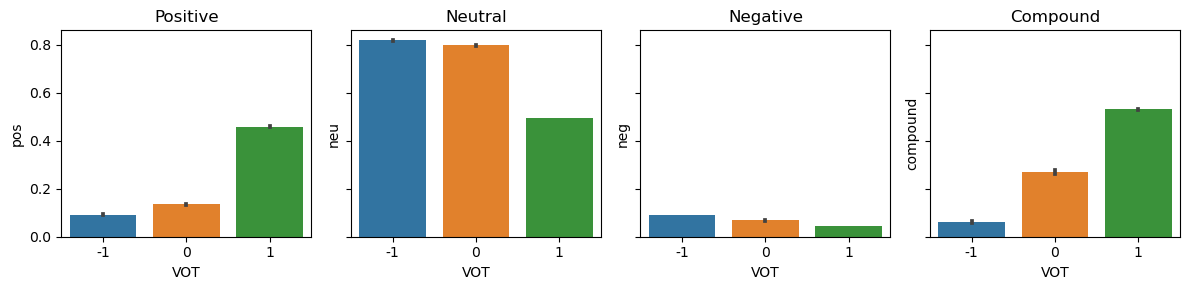

In [33]:
wiki_cle_dropna = wiki_with_scores.dropna(subset = 'CLE') # remove empty comments 
fig, axs = plt.subplots(1, 4, figsize=(12, 3),  sharey = True)
sns.barplot(data=wiki_cle_dropna, x='VOT', y='pos', ax=axs[0])
sns.barplot(data=wiki_cle_dropna, x='VOT', y='neu', ax=axs[1])
sns.barplot(data=wiki_cle_dropna, x='VOT', y='neg', ax=axs[2])
sns.barplot(data=wiki_cle_dropna, x='VOT', y='compound', ax=axs[3])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
axs[3].set_title('Compound')
plt.tight_layout()
plt.show()

Considering the Compound score that merges negative, neutral and positive scores, we can conclude that there is consistency on average between the votes and the associated comments.

In [34]:
compound_per_year = wiki_cle_dropna.groupby(['YEA', 'VOT'])['compound'].mean().reset_index()
compound_per_year.head(9)

,YEA,VOT,compound
0,2003,-1,-0.020150
1,2003,0,0.000000
2,2003,1,0.466455
3,2004,-1,0.076583
4,2004,0,0.192388
5,2004,1,0.399298
6,2005,-1,0.058232
7,2005,0,0.254654
8,2005,1,0.493900


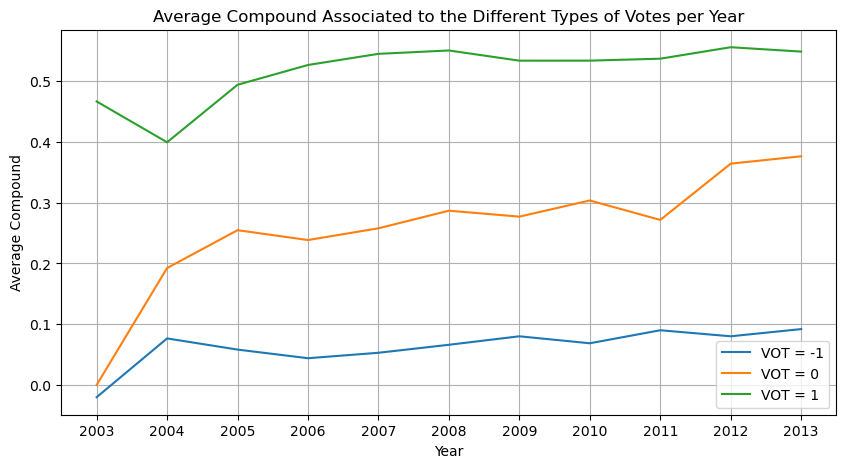

In [35]:
plt.figure(figsize=(10, 5))

for vot in [-1, 0, 1]: 
    sub_df = compound_per_year[compound_per_year['VOT'] == vot]
    plt.plot(sub_df['YEA'], sub_df['compound'], label = 'VOT = '+ str(vot))

plt.title('Average Compound Associated to the Different Types of Votes per Year')
plt.xticks(np.arange(2003, 2014))
plt.xlabel('Year')
plt.ylabel('Average Compound')
plt.grid()
plt.legend()

* For each year, the conclusion of consistency is still available. Therefore, generally, people tend to leave comments accordingly to their vote choice.

# Sentiment analysis with TextBlob

In this section, we will use TextBlob, a powerful library for processing textual data, in order to extract the sentiment polarity and subjectivity of each comment.

**Notes:** 
* The *polarity* ranges from -1 (indicating negativity) to 1 (indicating positivity)
* The *subjectivity* ranges from 0 (reflecting objectivity) and 1 (reflecting subjectivity).

To achieve that, we have to do additional processing on the comments. 

In [36]:
wiki_copy['CLE'] = wiki_copy['CLE'].apply(nlp_pipeline) 
wiki_copy.head()

,SRC,TGT,VOT,RES,YEA,DAT,TXT,ELECTION_ID,CLE
0,Steel1943,BDD,1,1,2013,2013-04-19 23:13:00,'''Support''' as co-nom.,1,support as conom.
1,Cuchullain,BDD,1,1,2013,2013-04-20 01:04:00,'''Support''' as nominator.--,1,support as nominator.
2,INeverCry,BDD,1,1,2013,2013-04-19 23:43:00,'''Support''' per noms.,1,support per noms.
3,Cncmaster,BDD,1,1,2013,2013-04-20 00:11:00,'''Support''' per noms. BDD is a strong contri...,1,support per noms. bdd is a strong contributor ...
4,Miniapolis,BDD,1,1,2013,2013-04-20 00:56:00,"'''Support''', with great pleasure. I work wit...",1,support with great pleasure. i work with bdd a...


In [37]:
# Remove the first word of each comment if contained on the list below
# to avoid a bias on the algorithm
wiki_copy['CLE'] = wiki_copy['CLE'].str.replace('^(support|oppose|neutral|strong support|weak support|happy support|unfortunate oppose) ', '', regex=True)
wiki_copy.head()

,SRC,TGT,VOT,RES,YEA,DAT,TXT,ELECTION_ID,CLE
0,Steel1943,BDD,1,1,2013,2013-04-19 23:13:00,'''Support''' as co-nom.,1,as conom.
1,Cuchullain,BDD,1,1,2013,2013-04-20 01:04:00,'''Support''' as nominator.--,1,as nominator.
2,INeverCry,BDD,1,1,2013,2013-04-19 23:43:00,'''Support''' per noms.,1,per noms.
3,Cncmaster,BDD,1,1,2013,2013-04-20 00:11:00,'''Support''' per noms. BDD is a strong contri...,1,per noms. bdd is a strong contributor with tho...
4,Miniapolis,BDD,1,1,2013,2013-04-20 00:56:00,"'''Support''', with great pleasure. I work wit...",1,with great pleasure. i work with bdd at the wh...


In [38]:
# Show the first 10 comments completely
pd.set_option('display.max_colwidth', None)
print(wiki_copy['CLE'].head(10))
pd.reset_option('display.max_colwidth')

0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  as conom.
1                                                                                                                                                                                                                                                                                                                                                                          

In [39]:
def polarity(text):  
    '''extracts the polarity of the text sentiment'''
    pol = TextBlob(text)
    return pol.sentiment.polarity

def subjectivity(text):
    '''extracts the subjectivity of the text sentiment'''
    pol = TextBlob(text)
    return pol.sentiment.subjectivity

In [40]:
# Add the polarity and the subjectivity to our dataframe
wiki_copy['polarity'] = wiki_copy['CLE'].apply(polarity)
wiki_copy['subjectivity'] = wiki_copy['CLE'].apply(subjectivity)
wiki_copy.head()

,SRC,TGT,VOT,RES,YEA,DAT,TXT,ELECTION_ID,CLE,polarity,subjectivity
0,Steel1943,BDD,1,1,2013,2013-04-19 23:13:00,'''Support''' as co-nom.,1,as conom.,0.000000,0.000000
1,Cuchullain,BDD,1,1,2013,2013-04-20 01:04:00,'''Support''' as nominator.--,1,as nominator.,0.000000,0.000000
2,INeverCry,BDD,1,1,2013,2013-04-19 23:43:00,'''Support''' per noms.,1,per noms.,0.000000,0.000000
3,Cncmaster,BDD,1,1,2013,2013-04-20 00:11:00,'''Support''' per noms. BDD is a strong contri...,1,per noms. bdd is a strong contributor with tho...,0.341667,0.491667
4,Miniapolis,BDD,1,1,2013,2013-04-20 00:56:00,"'''Support''', with great pleasure. I work wit...",1,with great pleasure. i work with bdd at the wh...,0.638889,0.616667


When we look at the 3 first comments, they have 0 as polarity and 0 as subjectivity. The algorithm does not get any information from comments that are too short or meaningless. Therefore, we are going to show the distribution of the polarity for different levels of subjectivity.

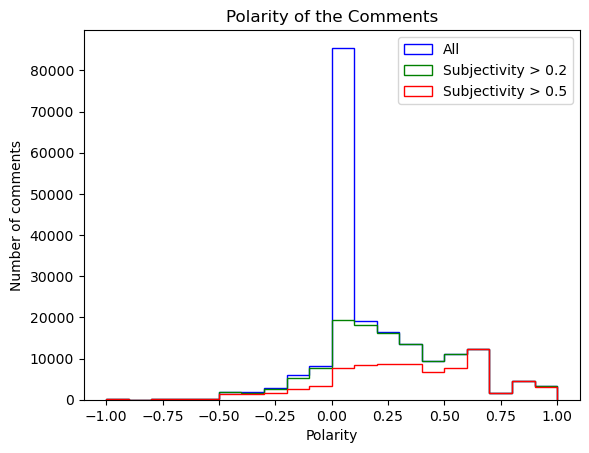

In [41]:
fig,ax = plt.subplots()
ax.hist(wiki_copy["polarity"],bins=20, histtype="step", label='All',color='b')
wiki_copy_subjectif = wiki_copy[wiki_copy['subjectivity'] > 0.2] 
ax.hist(wiki_copy_subjectif["polarity"],bins=20, histtype="step", label='Subjectivity > 0.2',color='g')
wiki_copy_subjectif = wiki_copy[wiki_copy['subjectivity'] > 0.5] 
ax.hist(wiki_copy_subjectif["polarity"],bins=20, histtype="step", label='Subjectivity > 0.5',color='r')
plt.xlabel('Polarity')
plt.ylabel('Number of comments')
plt.title('Polarity of the Comments')
plt.legend()
plt.show()

We observe that many comments show a polarity of 0 indicating a lack of subjectivity. We suppose that they are too brief to provide any interesting information. So to explore this further, we need to display the comments length for each level of subjectivity.

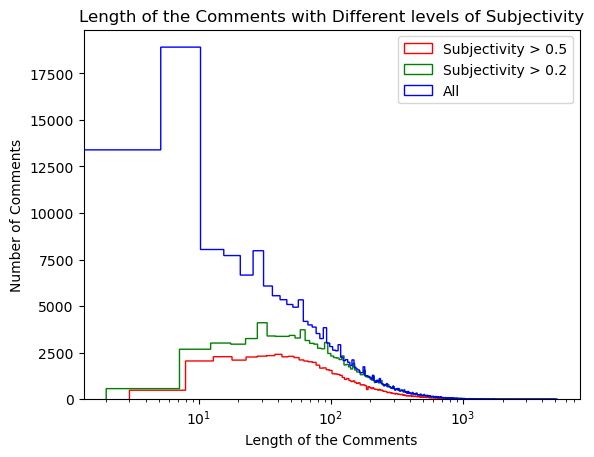

In [42]:
# Graph of the length of the comments for all the comments ( in blue) 
# and for the subjective comments (with subjectivity score more than 0.2 in green and 0.5 in red)
fig,ax = plt.subplots() 
ax.hist(wiki_copy[wiki_copy['subjectivity'] > 0.5]['CLE'].str.len(),bins=1000, histtype="step", label='Subjectivity > 0.5',color='r')
ax.hist(wiki_copy[wiki_copy['subjectivity'] > 0.2]['CLE'].str.len(),bins=1000, histtype="step", label='Subjectivity > 0.2',color='g')
ax.hist(wiki_copy['CLE'].str.len(),bins=1000, histtype="step", label='All',color='b')
plt.xlabel('Length of the Comments')
plt.ylabel('Number of Comments')
plt.title('Length of the Comments with Different levels of Subjectivity')
plt.xscale('log')
plt.legend()
plt.show()

Many comments appear too brief to provide substantial information. To ensure meaningful insights, we have established a subjectivity threshold of 0.2. Consequently, during our comment exploration, we exclusively utilize the subjective dataframe. Our objective is to enhance the quality of our results by keeping only those comments that are considered more interesting and informative.

In [43]:
# new dataframe with only subjective comments for the rest of our analysis
df_subjectiv = wiki_copy[wiki_copy['subjectivity'] > 0.2] 

## Length of the comments

In this part, we explore the correlation between the length of the comment and the subjectivity.

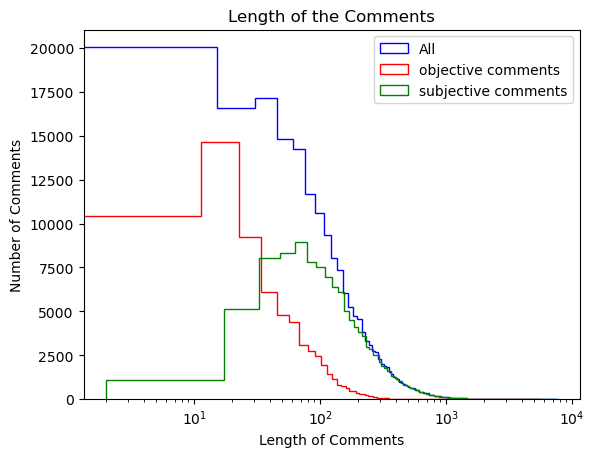

In [44]:
fig,ax = plt.subplots() 
ax.hist(wiki_copy['TXT'].str.len(),bins=500, histtype="step", label='All',color='b')
ax.hist(wiki_copy[wiki_copy['subjectivity'] < 0.2]['TXT'].str.len(),bins=500, histtype="step", label='objective comments',color='r')
ax.hist(wiki_copy[wiki_copy['subjectivity'] > 0.2]['TXT'].str.len(),bins=500, histtype="step", label='subjective comments',color='g')
plt.xlabel('Length of Comments')
plt.ylabel('Number of Comments')
plt.xscale('log')
plt.legend()
plt.title('Length of the Comments')
plt.show()

We note that typically, when a comment is excessively brief, it tends to be objective. Conversely, when a comment is more extensive in terms of characters, it is likely to be subjective.

## Topic of the comments

In this part, we will use the latent dirichlet allocation in order to cluster the comments in various topics. The main idea is to extract some interesting keywords from the comments, so that we can understand what are the criteria to achieve a successful election.

We start with processing text with spacy.

In [45]:
nlp = spacy.load("en_core_web_sm")
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\liand\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [46]:
def preprocess_text(text):
    ''' preprocesses text with lemmatization'''
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
    return " ".join(tokens)

In [47]:
def process_stop_word(text, stem="None"):
    '''removes stop words'''
    text = text.split()
    useless_words = nltk.corpus.stopwords.words("english")
    useless_words = useless_words + ['hi', 'im']
    text_filtered = [word for word in text if not word in useless_words]
        # Stem or Lemmatize
    if stem == 'Stem':
        stemmer = PorterStemmer() 
        text_stemmed = [stemmer.stem(y) for y in text_filtered]
    elif stem == 'Lem':
        lem = WordNetLemmatizer()
        text_stemmed = [lem.lemmatize(y) for y in text_filtered]
    elif stem == 'Spacy':
        text_filtered = nlp(' '.join(text_filtered))
        text_stemmed = [y.lemma_ for y in text_filtered]
    else:
        text_stemmed = text_filtered

    final_string = ' '.join(text_stemmed)

    return final_string

In [48]:
# Clean the text for the LDA algorithm
df_subjectiv['preprocessed_txt'] = df_subjectiv['CLE'].apply(preprocess_text)
df_subjectiv['preprocessed_txt'] = df_subjectiv['preprocessed_txt'].apply(process_stop_word)

C:\Users\liand\AppData\Local\Temp\ipykernel_9800\2082174653.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subjectiv['preprocessed_txt'] = df_subjectiv['CLE'].apply(preprocess_text)
C:\Users\liand\AppData\Local\Temp\ipykernel_9800\2082174653.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subjectiv['preprocessed_txt'] = df_subjectiv['preprocessed_txt'].apply(process_stop_word)


##### Transforming the preprocessed comments into a structured representation that captures the importance of terms within each comment using TF-IDF (Term Frequency-Inverse Document Frequency).

In [64]:
# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
# Apply TF-IDF vectorization to the preprocessed text
dtm = vectorizer.fit_transform(df_subjectiv['preprocessed_txt'])

In [65]:
# LDA model
num_topics = 25 # Classify into n topics to visualize some positive or negative topics
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(dtm)  # Fit the LDA model to the TF-IDF matrix

LatentDirichletAllocation(n_components=25, random_state=42)

In [66]:
def print_top_words(model, vectorizer, n_words=10):
    '''prints the 10 words that are the best of each topics'''
    feature_names = vectorizer.get_feature_names_out()
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[:-n_words - 1:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        print(f"Topic #{topic_idx + 1}: {' | '.join(top_words)}")

In [67]:
print_top_words(lda, vectorizer)

Topic #1: answer | question | good | support | weak | strongly | oppose | glad | worthy | attitude
Topic #2: wrong | month | rfa | support | deserve | try | experience | good | oppose | think
Topic #3: sorry | wikipedian | content | work | good | benefit | experience | support | afd | contribution
Topic #4: sure | guy | choice | support | okay | wonderful | good | seriously | conom | brilliant
Topic #5: nom | impressive | happy | support | friendly | big | deal | right | wow | time
Topic #6: ok | rfa | oppose | support | soon | mean | account | admin | capable | previous
Topic #7: oppose | support | good | admin | concern | rfa | love | comment | think | faith
Topic #8: head | new | cheer | sense | level | admin | good | support | common | dispute
Topic #9: reasonable | supportlook | obvious | good | wisely | support | constructive | man | place | use
Topic #10: oppose | admin | deletion | support | think | article | delete | candidate | close | afd
Topic #11: great | contributor | adm

We can now generate a topic number for all the comments in the dataframe:

In [68]:
# Add a column with the number of the topic for each comment
df_subjectiv.reset_index(drop=True, inplace=True)
df_subjectiv['Topic'] = df_subjectiv.index.map(lambda i: lda.transform(dtm[i]).argmax())
df_subjectiv.head()

C:\Users\liand\AppData\Local\Temp\ipykernel_9800\4101988350.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subjectiv['Topic'] = df_subjectiv.index.map(lambda i: lda.transform(dtm[i]).argmax())


,SRC,TGT,VOT,RES,YEA,DAT,TXT,ELECTION_ID,CLE,polarity,subjectivity,preprocessed_txt,Topic
0,Cncmaster,BDD,1,1,2013,2013-04-20 00:11:00,'''Support''' per noms. BDD is a strong contri...,1,per noms. bdd is a strong contributor with tho...,0.341667,0.491667,nom bdd strong contributor thousand edit year ...,22
1,Miniapolis,BDD,1,1,2013,2013-04-20 00:56:00,"'''Support''', with great pleasure. I work wit...",1,with great pleasure. i work with bdd at the wh...,0.638889,0.616667,great pleasure work bdd coordinator see good w...,12
2,Sven Manguard,BDD,1,1,2013,2013-04-20 01:53:00,'''Support''' There are plenty of important ro...,1,there are plenty of important roles on this pr...,0.375000,0.775000,plenty important role project content creator ...,19
3,RockMagnetist,BDD,1,1,2013,2013-04-20 02:18:00,'''Support''' BDD already wields a broom pret...,1,bdd already wields a broom pretty well so why ...,0.095556,0.502963,bdd wield broom pretty formalize concerned lac...,22
4,Carrite,BDD,1,1,2013,2013-04-20 02:22:00,'''Support''' barring a completely unexpected ...,1,barring a completely unexpected answer to prof...,0.333214,0.529048,bar completely unexpected answer proforma ques...,15


We can visualize the polarity of each topics :

C:\Users\liand\anaconda3\envs\ada\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 0.98, 'Polarity of Different Topics')

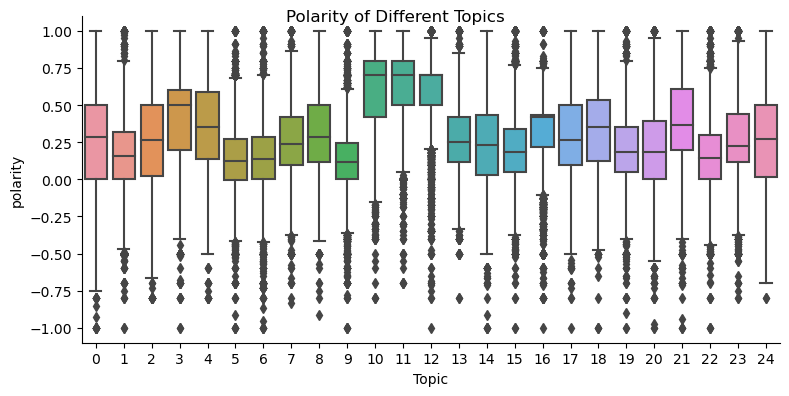

In [69]:
plot = sns.catplot(x='Topic', y='polarity', kind="box", data=df_subjectiv, errorbar='sd', height=4, aspect=2)
plot.fig.suptitle('Polarity of Different Topics')

By examining this plot, it becomes evident that topics 10-11-12 exhibits a higher polarity compared to the others. To delve deeper into the positive comments within this topic, we can inspect the list of prevalent words. Notable keywords include:
- positive
- interaction
- experienced
- helpful
- friendly

After reflection, we anticipate uncovering more insights by filtering comments exclusively for positive or negative sentiments.

## Repeat the same with the positive/negative comments

In this part, we are gonna use only the subjective comments with a polarity greater than 0,5. The goal is to extract the topics and keywords to gives us an idea of the positive comments.

In [54]:
# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
# Apply TF-IDF vectorization to the preprocessed text
dtm = vectorizer.fit_transform(df_subjectiv[df_subjectiv['polarity'] > 0.5]['preprocessed_txt'])

# LDA model
num_topics = 20 #separation in 20 topics to visualize some positive or negative topics
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(dtm)  # Fit the LDA model to the TF-IDF matrix

LatentDirichletAllocation(n_components=20, random_state=42)

In [55]:
print_top_words(lda, vectorizer)

Topic #1: luck | good | vandal | supportlook | fighter | support | vandalism | revert | great | mop
Topic #2: job | experience | good | great | area | benefit | project | support | admin | wikipedia
Topic #3: sound | deserve | good | addition | support | editor | superb | admin | great | dedicated
Topic #4: admin | great | good | editor | support | think | excellent | strong | sure | user
Topic #5: nom | contribution | good | support | head | great | excellent | admin | material | judgement
Topic #6: fine | record | track | perfect | good | clueful | support | admin | attitude | judgment
Topic #7: answer | question | good | edit | support | contribution | excellent | great | summary | like
Topic #8: guy | nice | choice | awesome | good | support | wikipedia | helpful | talk | page
Topic #9: use | tool | mop | good | wisely | appear | editor | time | user | admin
Topic #10: look | good | support | like | meet | great | brilliant | criterion | welcome | happily
Topic #11: impressed | con

Some other interesting positive words :
- trustworthy
- contribution
- experience
- asset
- friendly
- work
- project 
- fighter 
- helpful 
- ...

These terms serve as valuable criterias to the acceptance of a person.

Then with the negative comments, with polarity smaller than -0,5.

In [56]:
# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
# Apply TF-IDF vectorization to the preprocessed text
dtm = vectorizer.fit_transform(df_subjectiv[df_subjectiv['polarity'] < 0]['preprocessed_txt'])

# LDA model
num_topics = 20 #separation in 20 topics to visualize some positive or negative topics
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(dtm)  # Fit the LDA model to the TF-IDF matrix

LatentDirichletAllocation(n_components=20, random_state=42)

In [57]:
print_top_words(lda, vectorizer)

Topic #1: major | concern | vandal | block | positive | problem | user | log | personal | net
Topic #2: real | oppose | support | feeling | inexperience | reason | userbox | queue | obvious | pointless
Topic #3: sorry | oppose | experience | ridiculous | hate | support | concern | new | edit | random
Topic #4: sure | overdue | long | deal | big | supporti | support | reason | stupid | admin
Topic #5: article | afd | oppose | delete | candidate | close | admin | support | deletion | rfa
Topic #6: page | signature | username | edit | talk | pile | user | oppose | odd | support
Topic #7: answer | question | good | oppose | bad | reason | support | sorry | admin | vague
Topic #8: fail | oppose | poor | rfa | careful | support | silly | user | uncivil | unnecessary
Topic #9: edit | experience | lack | little | low | mainspace | count | article | area | oppose
Topic #10: opposeper | comfortable | evil | oppose | admin | candidate | english | terrible | weird | time
Topic #11: abuse | unlikel

From this word list, we can infer certain criteria indicative of non-acceptance:
- uncivil
- stupid
- immature
- overdue 
- silly 
- inexperienced  


## Which words are most frequently utilized in the comments?

In [58]:
all_text = ' '.join(df_subjectiv['preprocessed_txt'].astype(str))
all_text_p = ' '.join(df_subjectiv[df_subjectiv['polarity'] > 0.5]['preprocessed_txt'].astype(str))
all_text_n = ' '.join(df_subjectiv[df_subjectiv['polarity'] < -0.5]['preprocessed_txt'].astype(str))

# Tokenize the text into words
words = re.findall(r'\b\w+\b', all_text.lower())
words_p = re.findall(r'\b\w+\b', all_text_p.lower())
words_n = re.findall(r'\b\w+\b', all_text_n.lower())


# count occurrences of each word
word_counts = Counter(words)
word_counts_p = Counter(words_p)
word_counts_n = Counter(words_n)

# Print the most common words and their counts for all/positive/negative comments
print('Most common words in all the comments : \n', word_counts.most_common(20),'\n')
print('Most common words the positive comments : \n', word_counts_p.most_common(20),'\n')
print('Most common words the negative comments : \n', word_counts_n.most_common(20),'\n')

Most common words in all the comments : 
 [('good', 44827), ('support', 41769), ('admin', 35116), ('edit', 26420), ('user', 24785), ('oppose', 23884), ('editor', 22025), ('candidate', 18308), ('work', 18066), ('think', 17112), ('tool', 16240), ('experience', 16122), ('like', 15094), ('answer', 14354), ('time', 14308), ('article', 13735), ('need', 13342), ('rfa', 12845), ('great', 12413), ('question', 12133)] 

Most common words the positive comments : 
 [('good', 18123), ('support', 7265), ('great', 5935), ('admin', 5397), ('editor', 4859), ('user', 4234), ('excellent', 3784), ('candidate', 3092), ('work', 2935), ('look', 2746), ('answer', 2312), ('like', 2079), ('tool', 2068), ('luck', 1921), ('edit', 1703), ('question', 1576), ('contribution', 1566), ('see', 1560), ('think', 1475), ('experience', 1441)] 

Most common words the negative comments : 
 [('bad', 170), ('support', 122), ('oppose', 100), ('admin', 89), ('hate', 51), ('user', 47), ('think', 43), ('tool', 41), ('reason', 40),